# Problem Statement

Develop a robust classification model for accurately identifying and classifying plant diseases based on provided Kaggle dataset. The dataset contains a large collection of images representing various plant species and their associated diseases. The objective is to leverage machine learning techniques to build a highly accurate and efficient model that can assist in automated plant disease diagnosis and contribute to early detection and prevention efforts.

The model should be capable of effectively distinguishing between healthy plants and those affected by diseases, accurately identifying the specific disease type present, and providing reliable predictions for new, unseen plant images. By addressing this problem, we aim to support farmers, agricultural experts, and researchers in their efforts to monitor and manage plant health, enhance crop productivity, and minimize losses caused by diseases.

Key deliverables for the project include a well-performing machine learning model with high classification accuracy, an end-to-end pipeline for preprocessing and augmenting the dataset, feature extraction, model training, and evaluation. Additionally, the project should provide comprehensive documentation detailing the methodology, model architecture, and guidelines for model deployment and integration into existing agricultural systems.

Successful completion of this project will contribute to the development of a powerful tool for early disease detection and monitoring in plants, thereby enabling timely interventions, reducing crop losses, and promoting sustainable agriculture practices.

Dataset link:-https://www.kaggle.com/datasets/arjuntejaswi/plant-village

## Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=15

## Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"dataset\PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Visualize some of the images from our dataset

(32, 256, 256, 3)
[0 1 0 0 2 2 1 1 0 0 1 2 0 2 1 1 2 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0]


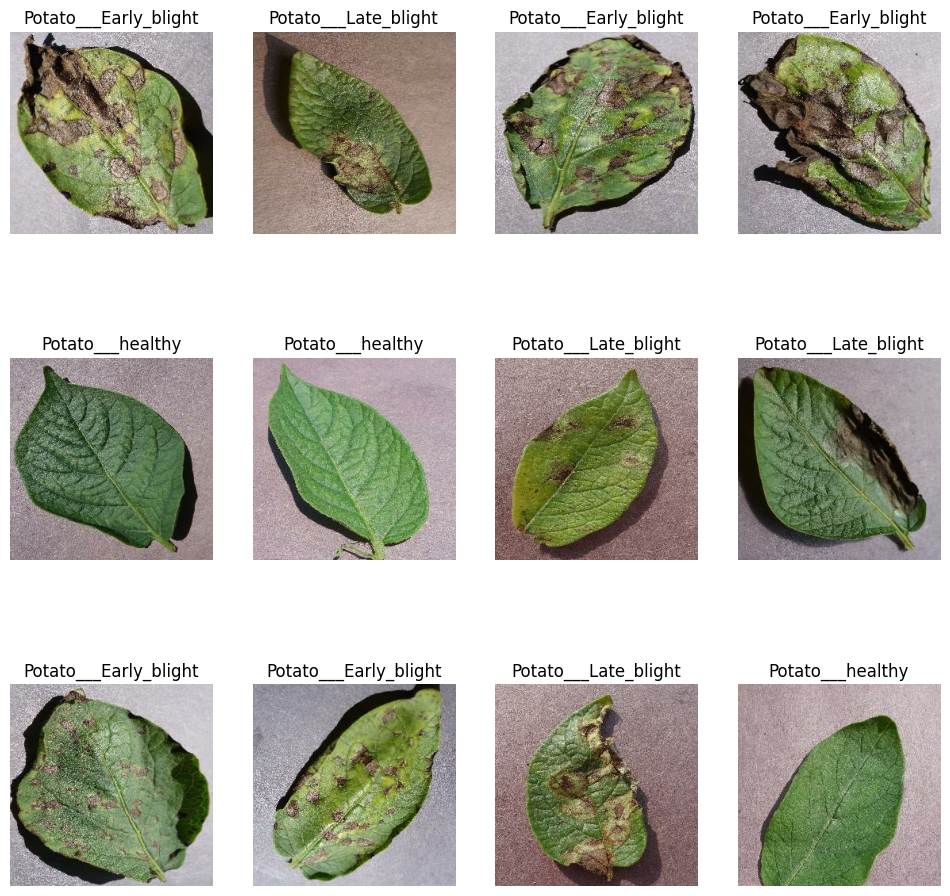

In [5]:
plt.figure(figsize=(12,12))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(val_ds)

8

In [10]:
len(test_ds)

6

## Cache, Shuffle, and Prefetch the Dataset

In [11]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.6784314  0.59607846 0.5921569 ]
  [0.49803922 0.41568628 0.4117647 ]
  [0.6313726  0.54901963 0.54509807]
  ...
  [0.7058824  0.62352943 0.61960787]
  [0.78039217 0.69803923 0.69411767]
  [0.6627451  0.5803922  0.5764706 ]]

 [[0.7019608  0.61960787 0.6156863 ]
  [0.81960785 0.7372549  0.73333335]
  [0.8039216  0.72156864 0.7176471 ]
  ...
  [0.6431373  0.56078434 0.5568628 ]
  [0.6117647  0.5294118  0.5254902 ]
  [0.6313726  0.54901963 0.54509807]]

 [[0.61960787 0.5372549  0.53333336]
  [0.65882355 0.5764706  0.57254905]
  [0.4117647  0.32941177 0.3254902 ]
  ...
  [0.5647059  0.48235294 0.47843137]
  [0.60784316 0.5254902  0.52156866]
  [0.69803923 0.6156863  0.6117647 ]]

 ...

 [[0.43137255 0.30980393 0.3019608 ]
  [0.58431375 0.4627451  0.45490196]
  [0.43529412 0.3137255  0.30588236]
  ...
  [0.5529412  0.44313726 0.4392157 ]
  [0.47058824 0.36078432 0.35686275]
  [0.5882353  0.47843137 0.4745098 ]]

 [[0.4509804  0.32941177 0.32156864]
  [0.4745098  0.3529412  0.34509805]


In [13]:
# image resizing and rescaling...
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [14]:
# image Augmentation...
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(10.2)
    
])

In [15]:
BATCH_SIZE


32

## Model training

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
#     data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
# model = tf.keras.Sequential([
#   resize_and_rescale,

#   layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
#   layers.MaxPooling2D((2,2)),
#   layers.Conv2D(32, 3, activation='relu'),
#   layers.MaxPooling2D((2,2)),
#   layers.Conv2D(32, 3, activation='relu'),
#   layers.MaxPooling2D((2,2)),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(n_classes, activation='softmax'),
# ])

# model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/15
54/54 [==============================] - 91s 2s/step - loss: 0.9142 - accuracy: 0.4711 - val_loss: 0.8953 - val_accuracy: 0.4453
Epoch 2/15
54/54 [==============================] - 111s 2s/step - loss: 0.7757 - accuracy: 0.6094 - val_loss: 0.5816 - val_accuracy: 0.7070
Epoch 3/15
54/54 [==============================] - 98s 2s/step - loss: 0.4822 - accuracy: 0.7847 - val_loss: 0.5436 - val_accuracy: 0.7734
Epoch 4/15
54/54 [==============================] - 92s 2s/step - loss: 0.3245 - accuracy: 0.8727 - val_loss: 0.3059 - val_accuracy: 0.9023
Epoch 5/15
54/54 [==============================] - 100s 2s/step - loss: 0.2325 - accuracy: 0.9103 - val_loss: 0.2227 - val_accuracy: 0.9102
Epoch 6/15
54/54 [==============================] - 109s 2s/step - loss: 0.2211 - accuracy: 0.9161 - val_loss: 0.1976 - val_accuracy: 0.9258
Epoch 7/15
54/54 [==============================] - 92s 2s/step - loss: 0.1344 - accuracy: 0.9514 - val_loss: 0.0640 - val_accuracy: 0.9922
Epoch 8/15
54/54 

In [20]:
len(test_ds)

6

In [21]:
scores=model.evaluate(test_ds)

6/6 [==============================] - 5s 452ms/step - loss: 0.0310 - accuracy: 0.9844


In [22]:
scores

[0.031014323234558105, 0.984375]

## Plotting the Accuracy and Loss Curves

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
history.history['loss']

[0.9141844511032104,
 0.7756890058517456,
 0.4821993112564087,
 0.3244527280330658,
 0.23245389759540558,
 0.22113505005836487,
 0.13436400890350342,
 0.11679298430681229,
 0.0658038929104805,
 0.059029340744018555,
 0.03047967329621315,
 0.040778450667858124,
 0.037151534110307693,
 0.05589504912495613,
 0.064534492790699]

In [25]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

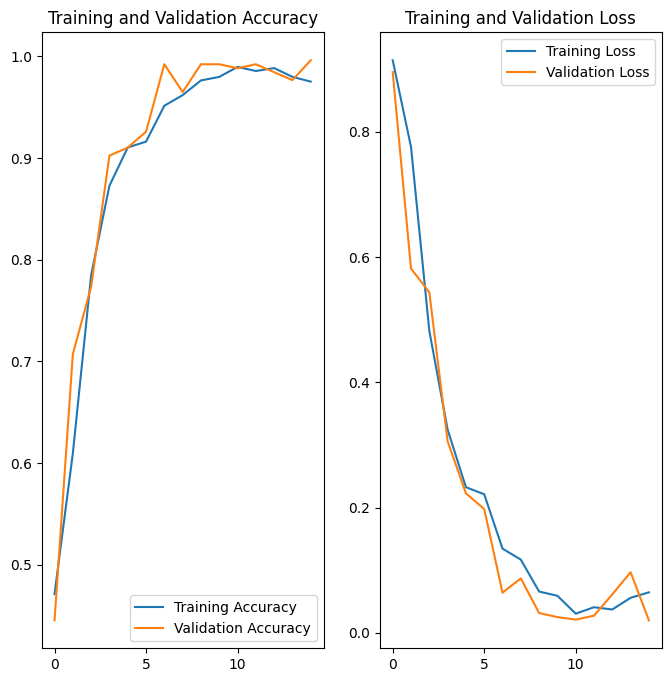

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

First image to predict
Actual Label: Potato___Early_blight
1/1 [==============================] - 1s 537ms/step
Predicted Label: Potato___Early_blight


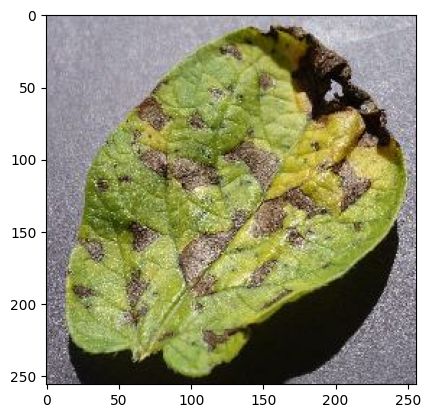

In [28]:
import numpy as np
for images_batch, labels_batch in dataset.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

1/1 [==============================] - 0s 30ms/step


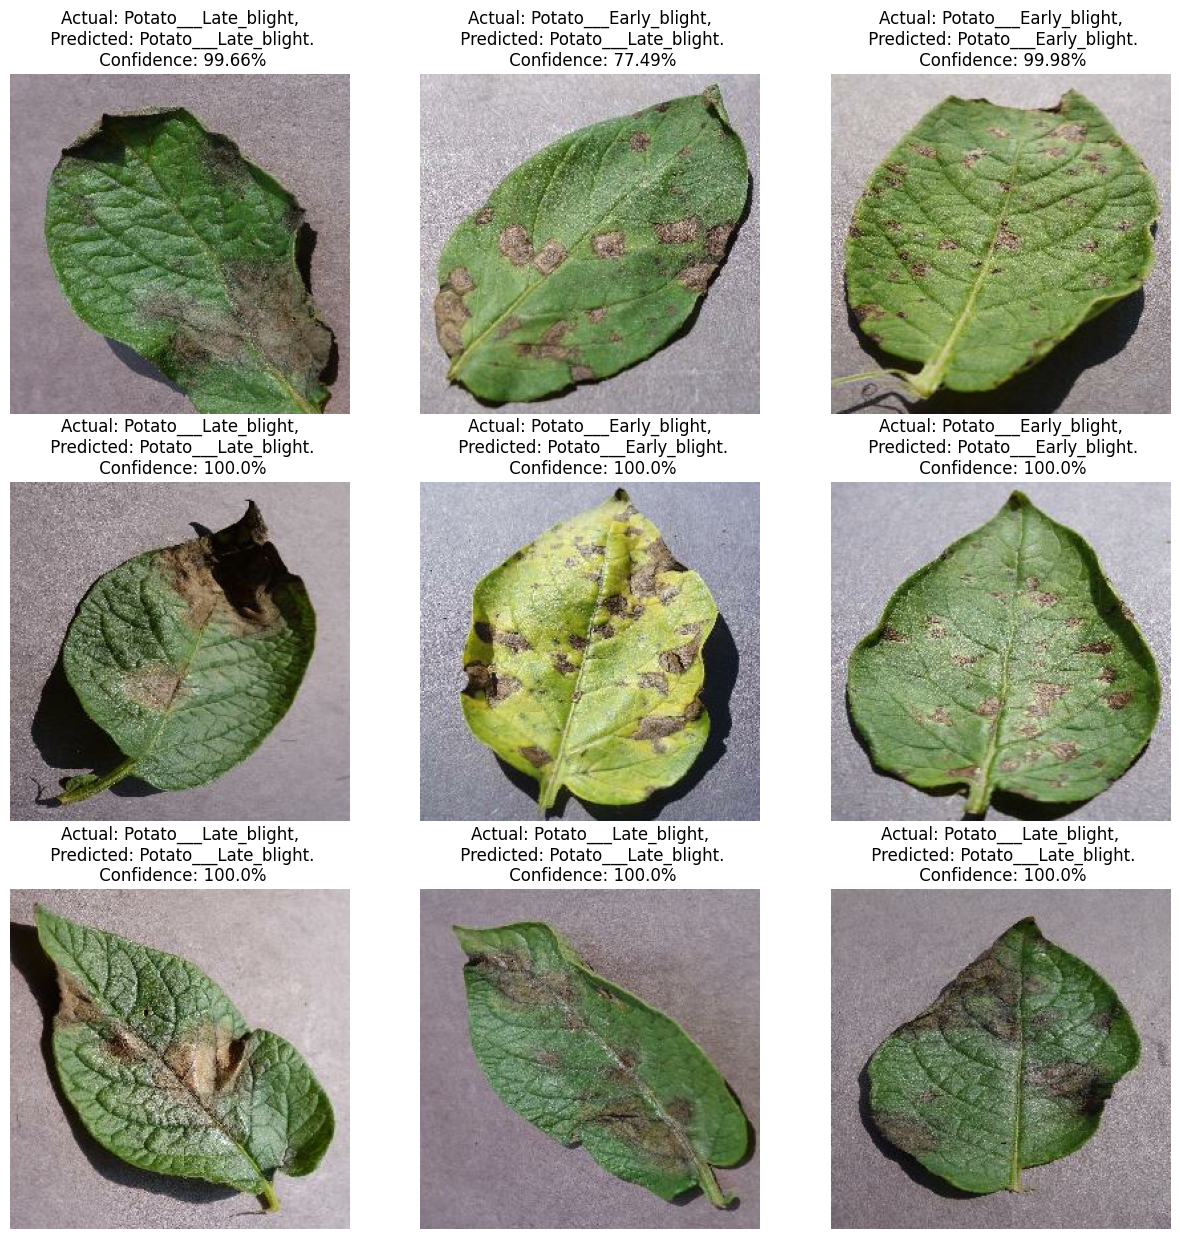

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model
We append the model to the list of models as a new version

In [34]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")


INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
